Average Weekly Earnings: We extract [Weekly Earnings (KAB9)] of the [Whole Economy]
    Observations start: January 2000

CPIH Index: Base year is 2015 (2015=100)
    Obsevations start: 2000 JAN

Productivity: [UK Whole Economy: Output per hour worked SA: Index 2022 = 100] -- this is the column we extract from the dataset since it is in index form
    Observations start: Q1 2000

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
xls = pd.ExcelFile("data/raw/awe.xls")
print(xls.sheet_names)

#Skip the first 8 rows which contain title and text
awe = pd.read_excel("data/raw/awe.xls", sheet_name = "1. AWE Total Pay", skiprows=9, header=None)
#Skip the first 8 rows which contain title and text
cpi = pd.read_csv("data/raw/cpi_index.csv", skiprows=8, header=None)
prod = pd.read_excel("data/raw/prdy.xlsx")

# Filtering columns of Average Weekly Earnings -- the dataset starts from January 2000
awe = awe[[0,1]]
awe.columns = ['Date', 'AWE']

#Drops rows where Weekly Earnings column is empty -- used for some empty text cells
awe.dropna(subset=['AWE'], inplace=True)

# Filtering columns of CPIH dataset -- starting from January 2000
cpi = cpi[[0,1]]
cpi.columns = ['Date', 'CPIH']

start_idx = cpi.loc[cpi['Date'].str.startswith('2000 JAN')].index[0]
cpi = cpi.loc[start_idx:].reset_index(drop=True)


# Filtering columns of productivity dataset - starting from Q1 of 2000
prod = prod[['Title', 'UK Whole Economy: Output per hour worked SA: Index 2022 = 100']]
prod = prod.rename(columns={'Title': 'Date',
                            'UK Whole Economy: Output per hour worked SA: Index 2022 = 100': 'OutputHR'})

start_idx = prod.loc[prod['Date'].str.startswith('2000 Q1')].index[0]
prod = prod.loc[start_idx:].reset_index(drop=True)

['Introduction', '1. AWE Total Pay', '2. AWE Bonus Pay', '3. AWE Regular Pay', '4. AWE Total Pay Index', '5. AWE Regular Pay Index', '6. Real AWE', 'Sampling Variability']


C:\Users\andre\PycharmProjects\uk_inflation_wage_project\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
# We expect 1-to-1 for awe and cpi, call shape to confirm
print(cpi.shape)
print(awe.shape)

# We call tail to see why there is one extra observation -- CPI has a September observation
print(cpi.tail())
print(awe.tail())

# Dropping last observation
cpi = cpi[0:-1]

# Converting both datasets to datetime
cpi['Date'] = pd.to_datetime(cpi['Date'], format = '%Y %b')
awe['Date'] = pd.to_datetime(awe['Date'])

# Converting columns to Month objects
cpi['Month'] = cpi['Date'].dt.to_period('M')
awe['Month'] = awe['Date'].dt.to_period('M')

# Merging on month
ts = pd.merge(cpi, awe, how='inner', on=['Month'])

# Dropping unused date columns and setting index to Month
ts.drop(columns=['Date_x', 'Date_y'], inplace=True)
ts.set_index('Month', inplace=True)

ts.head()


(309, 2)
(308, 2)
         Date   CPIH
304  2025 MAY  138.0
305  2025 JUN  138.4
306  2025 JUL  138.5
307  2025 AUG  138.9
308  2025 SEP  138.9
                    Date         AWE
303  2025-04-01 00:00:00  719.763788
304  2025-05-01 00:00:00  722.569363
305  2025-06-01 00:00:00  724.738409
306  2025-07-01 00:00:00  728.291840
307  2025-08-01 00:00:00  732.815546


,CPIH,AWE
Month,,
2000-01,72.6,304.722925
2000-02,72.8,299.818577
2000-03,73.0,311.418715
2000-04,73.3,308.748756
2000-05,73.5,311.178774


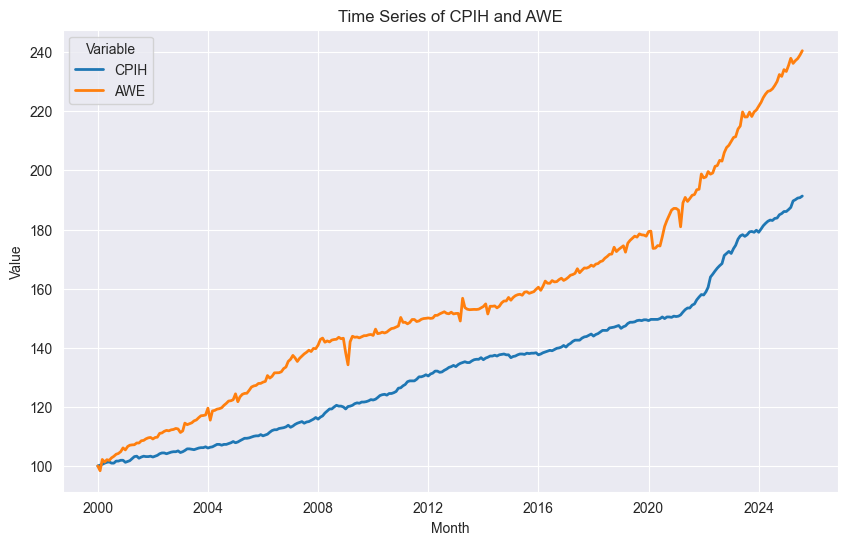

In [6]:
# Melting data for seaborn
ts_plot = ts.copy()
ts_plot = ts_plot.reset_index()
ts_plot.head()
ts_plot = ts_plot.melt(id_vars=['Month'], value_vars=['CPIH', 'AWE'], var_name='Variable', value_name='Value')

# Normalizing to show trends
ts_plot['Value_norm'] = ts_plot.groupby('Variable')['Value'].transform(lambda x: x / x.iloc[0] * 100)

# Formatting issues - need to convert to datetime
ts_plot['Month'] = ts_plot['Month'].dt.to_timestamp()

# Setting up plots
plt.figure(figsize=(10,6))
sns.lineplot(
    data=ts_plot,
    x='Month',
    y='Value_norm',
    hue='Variable',
    linewidth=2
)
plt.title('Time Series of CPIH and AWE')
plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

In [7]:
# Transforming Quarter strings for PeriodIndex to recognize
prod['Date'] = prod['Date'].apply(lambda x: x.replace(' ', ''))
prod['Quarter'] = pd.PeriodIndex(prod['Date'], freq='Q')

# Creating a copy of the merged dataframe
ts_prod = ts.copy()
# Converting index to timestamp
ts_prod.index = ts_prod.index.to_timestamp(how='start')

# Converting to timestamp
prod['Date_q'] = prod['Quarter'].dt.to_timestamp()

# Setting index and resampling
prod.set_index('Date_q', inplace=True)
prod_monthly = prod.resample('MS').ffill()

# Dropping unused columns
prod_monthly.drop(['Date', 'Quarter'], axis=1, inplace=True)

# Reindexing on merged dataset's index, using forward-fill to fill values outside of data interval
prod_monthly_realign = prod_monthly.reindex(ts_prod.index, method='ffill')

# Adding reindexed column to ts_prod as 'Productivity'
ts_prod['Productivity'] = prod_monthly_realign['OutputHR']

#Missing first row so fill in
ts_prod.at[ts_prod.index[0], 'Productivity'] = ts_prod['Productivity'].iloc[1]

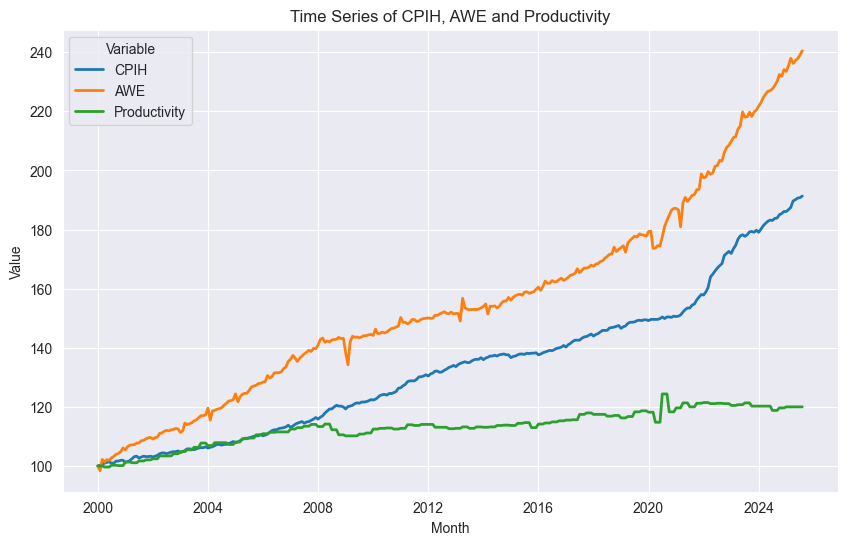

In [8]:
# Melting data for seaborn
ts_plot_prod = ts_prod.copy()
ts_plot_prod = ts_plot_prod.reset_index()
ts_plot_prod = ts_plot_prod.melt(id_vars=['Month'], value_vars=['CPIH', 'AWE', 'Productivity'], var_name='Variable', value_name='Value')

# Normalizing to show trends
ts_plot_prod['Value_norm'] = ts_plot_prod.groupby('Variable')['Value'].transform(lambda x: x / x.iloc[0] * 100)

# Setting up plots
plt.figure(figsize=(10,6))
sns.lineplot(
    data=ts_plot_prod,
    x='Month',
    y='Value_norm',
    hue='Variable',
    linewidth=2
)
plt.title('Time Series of CPIH, AWE and Productivity')
plt.xlabel('Month')
plt.ylabel('Value')
plt.show()

From the plot we can see that productivity and weekly earnings followed the same trajectory, until productivity decouples from 2008 and onwards. It is then very flat with a dip and spike in 2020-2021. These two movements represent the 2008 recession and the COVID recession respectively.

<Figure size 1000x600 with 0 Axes>

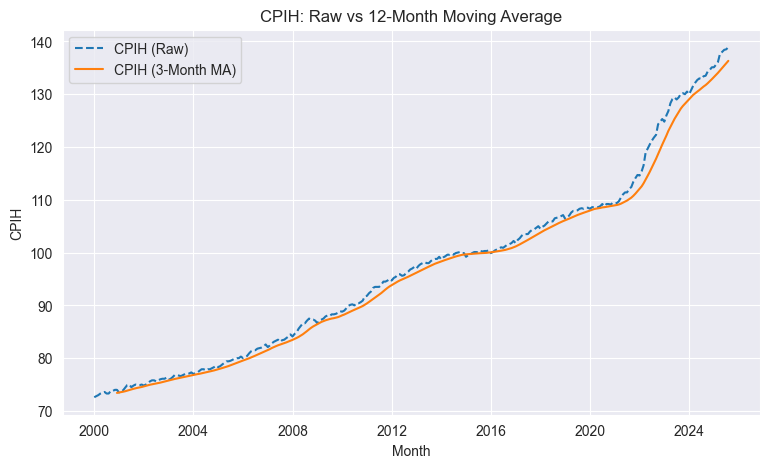

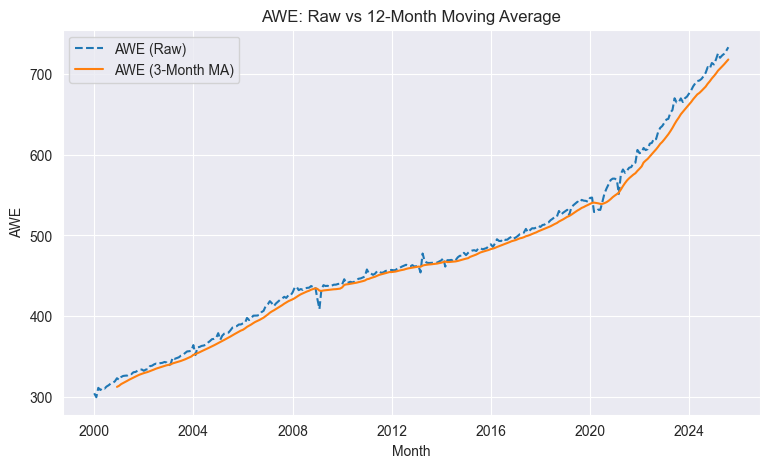

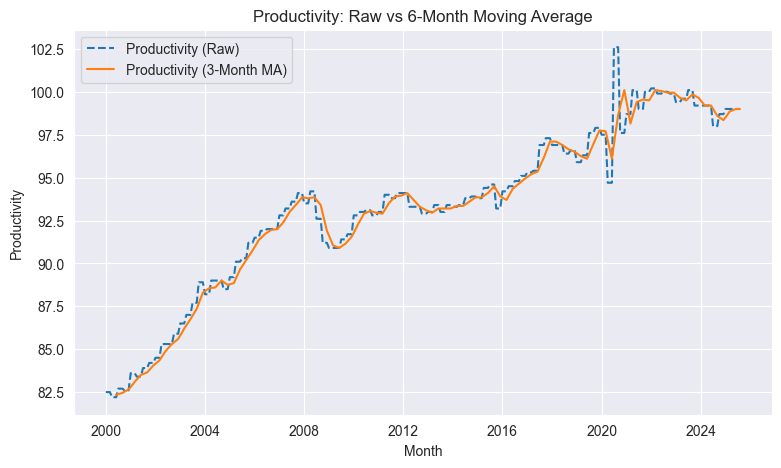

In [25]:
# Creating a copy of combined dataframe
ts_ma = ts_prod.copy()
# Calculating moving averages
ts_ma['CPIH_ma'] = ts_ma['CPIH'].rolling(window=12).mean()
ts_ma['AWE_ma'] = ts_ma['AWE'].rolling(window=12).mean()
ts_ma['Prod_ma'] = ts_ma['Productivity'].rolling(window=6).mean()

# Dropping empty values
ts_plot_ma.dropna(subset=['Value'], inplace=True)
plt.figure(figsize=(10,6))

# Plotting raw data and MA for each variable
var_list = [('CPIH', 'CPIH_ma'), ('AWE', 'AWE_ma'), ('Productivity', 'Prod_ma')]
for var, ma in var_list:
    plt.figure(figsize=(9, 5))
    sns.lineplot(data=ts_ma, x='Month', y=var, label=f'{var} (Raw)', linestyle='--')
    sns.lineplot(data=ts_ma, x='Month', y=ma, label=f'{var} (3-Month MA)')
    if var=='Productivity':
        plt.title(f'{var}: Raw vs 6-Month Moving Average')
    else:
        plt.title(f'{var}: Raw vs 12-Month Moving Average')
    plt.xlabel('Month')
    plt.ylabel(var)
    plt.legend()
    plt.show()


The moving average curves were computed at 12 month windows for CPIH and AWE since they are observed monthly. The productivity parameter was computed at a 6 month window since it is observed quarterly and a 12-month window would produce an overly smooth line without much information being communicated.

CPIH curve: Clear positive long-term growth but the momentum (gap between the two curves) rapidly increases after 2021

AWE curve: Positive long-term growth with instances where the raw data dips below the MA, slowing growth in the case of the 2008 Crisis and the Covid crisis. The Covid dip is more acute. These represent temporary shocks to the AWE variable. After the pandemic the curve mirrors the CPIH curve as the momentum picks up and the distance between the two curves increases

Productivity: Positive long-term growth with many temporary shocks. Large dip during the 2008 Crisis and dip then massive spike during the Covid pandemic. The gradual dip then slow recovery of 2008 can be explained by the nature of the crisis, the shock resulted in structural and cyclical unemployment. The shock was endogenously determined and follows a smooth U-shape. The pandemic was an exogenous shock to the entire world economy, the unemployment was sudden and caused a huge dip in productivity. Although some jobs were lost to frictional unemployment, most workers were facing temporary unemployment due to the government's lockdown policies. Once restrictions were eased the massive influx of workers returning to work caused an upward spike in productivity.
